**Import Libraries**

In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

**Import Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
datasetdir = '/content/drive/MyDrive/Bird'
os.chdir(datasetdir)


In [4]:
# Load file locations
df_info = pd.read_excel('dataset_information.xlsx', sheet_name = 'images.txt')

#Load class information
df_classes = pd.read_excel('dataset_information.xlsx', sheet_name = 'classes.txt')

In [5]:
df_classes.head(10)

,child_class_id,class_description
0,1,"Ducks, Geese, and Swans"
1,2,"Grouse, Quail, and Allies"
2,3,Loons
3,4,Grebes
4,5,Storks
5,6,"Frigatebirds, Boobies, Cormorants, Darters, an..."
6,7,"Pelicans, Herons, Ibises, and Allies"
7,8,"Hawks, Kites, Eagles, and Allies"
8,9,Caracaras and Falcons
9,10,Cranes and Rails


In [6]:
#Split the class and imange name
df_image = df_info.join(df_info['image_location'].str.split('/',expand=True).rename(columns={0:'class_id',1:'image_name'})) 

In [7]:
df_image.tail(10)

,image_id,image_location,class_id,image_name
48552,ffef2e23-edd7-4221-88a8-074ac0773d77,0786/ffef2e23edd7422188a8074ac0773d77.jpg,0786,ffef2e23edd7422188a8074ac0773d77.jpg
48553,ffef9325-d321-4129-825d-2d7dddeeb824,0980/ffef9325d3214129825d2d7dddeeb824.jpg,0980,ffef9325d3214129825d2d7dddeeb824.jpg
48554,fff0b2c3-5ab3-4c64-b160-a77398fe5a46,0527/fff0b2c35ab34c64b160a77398fe5a46.jpg,0527,fff0b2c35ab34c64b160a77398fe5a46.jpg
48555,fff1d97b-2ac3-410d-8c6d-7430470bb951,0503/fff1d97b2ac3410d8c6d7430470bb951.jpg,0503,fff1d97b2ac3410d8c6d7430470bb951.jpg
48556,fff3ec39-07d4-4600-b753-12013066277f,0999/fff3ec3907d44600b75312013066277f.jpg,0999,fff3ec3907d44600b75312013066277f.jpg
48557,fff86e8b-795f-400a-91e8-565bbb8c453a,0891/fff86e8b795f400a91e8565bbb8c453a.jpg,0891,fff86e8b795f400a91e8565bbb8c453a.jpg
48558,fff926d7-ccad-4788-839e-97af2dd99372,0660/fff926d7ccad4788839e97af2dd99372.jpg,0660,fff926d7ccad4788839e97af2dd99372.jpg
48559,fffa33ef-a765-408d-8d66-6efc7f504c71,0492/fffa33efa765408d8d666efc7f504c71.jpg,0492,fffa33efa765408d8d666efc7f504c71.jpg
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce,0372/ffff0d87bc844ef2a47ea4bfa48502ce.jpg,0372,ffff0d87bc844ef2a47ea4bfa48502ce.jpg
48561,fffff3a5-2a75-47d0-887f-03871e3f9a37,0880/fffff3a52a7547d0887f03871e3f9a37.jpg,0880,fffff3a52a7547d0887f03871e3f9a37.jpg


In [8]:
#Convert the string column to INT to chop leading zeroes
df_image['class_id'] = df_image['class_id'].astype(int)

In [9]:
#Join the information and class dataframe 
df_bird = pd.merge(df_image, df_classes, left_on='class_id', right_on='child_class_id', how='left').drop('child_class_id', axis=1)

In [10]:
df_bird.head(10)

,image_id,image_location,class_id,image_name,class_description
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,817,0000139e21dc4d0cbfe14cae3c85c829.jpg,Oak Titmouse
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,860,0000d9fc4e024c06a0afa55cfb16b12b.jpg,Ovenbird
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,900,000193069d834334b255a447742edce3.jpg,Savannah Sparrow
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,645,0001afd499a14a67b940d419413e23b3.jpg,Eared Grebe (Nonbreeding/juvenile)
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,929,000332b8997c454096472f0a8495aecf.jpg,Eastern Phoebe
5,000343bd-5215-49ba-ab9c-7c97a70ac1a5,0652/000343bd521549baab9c7c97a70ac1a5.jpg,652,000343bd521549baab9c7c97a70ac1a5.jpg,Yellow-crowned Night-Heron (Immature)
6,0004ff8d-0cc8-47ee-94ba-43352a8b9eb4,0951/0004ff8d0cc847ee94ba43352a8b9eb4.jpg,951,0004ff8d0cc847ee94ba43352a8b9eb4.jpg,Florida Scrub-Jay
7,0007181f-a727-4481-ad89-591200c61b9d,0900/0007181fa7274481ad89591200c61b9d.jpg,900,0007181fa7274481ad89591200c61b9d.jpg,Savannah Sparrow
8,00071e20-8156-4bd8-b5ca-6445c2560ee5,0988/00071e2081564bd8b5ca6445c2560ee5.jpg,988,00071e2081564bd8b5ca6445c2560ee5.jpg,Yellow-headed Blackbird (Female/Immature Male)
9,0007acfc-c0e6-4393-9ab6-02215a82ef63,0400/0007acfcc0e643939ab602215a82ef63.jpg,400,0007acfcc0e643939ab602215a82ef63.jpg,Herring Gull (Adult)


In [11]:
#Find the count of bird class in case only specific classes need to be to the model
df_bird.groupby(['class_id'])['class_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 

,class_id,count
523,979,120
446,902,120
275,672,120
80,397,120
400,856,120
...,...,...
550,1006,25
299,755,24
33,341,23
267,664,21


In [12]:
#Selected only specific label
#target_class = [397,672,856,902,979,298,817,860,900,645,929,652,951,900,755]
#target_class = [817,860,900,645,929,652,951,900,988,400,845,698,776,651,700,947,555,397,672,856,902,979,298]
target_class = [0]

df_bird['FILTERED_LABEL'] = (df_bird.class_id.isin(target_class)).astype('int')

In [13]:
#Random Check
df_bird[df_bird['class_id']==817]

,image_id,image_location,class_id,image_name,class_description,FILTERED_LABEL
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,817,0000139e21dc4d0cbfe14cae3c85c829.jpg,Oak Titmouse,0
305,01a472d8-e930-47a0-80aa-e4f958a2ef47,0817/01a472d8e93047a080aae4f958a2ef47.jpg,817,01a472d8e93047a080aae4f958a2ef47.jpg,Oak Titmouse,0
639,036fba7c-9637-4635-8535-11ead2c1c728,0817/036fba7c96374635853511ead2c1c728.jpg,817,036fba7c96374635853511ead2c1c728.jpg,Oak Titmouse,0
1410,07814887-f59b-44cb-9b7f-399999634fba,0817/07814887f59b44cb9b7f399999634fba.jpg,817,07814887f59b44cb9b7f399999634fba.jpg,Oak Titmouse,0
1530,08228657-41de-4312-8a6a-6c8897387975,0817/0822865741de43128a6a6c8897387975.jpg,817,0822865741de43128a6a6c8897387975.jpg,Oak Titmouse,0
...,...,...,...,...,...,...
45957,f227b5e7-ef0a-468f-be15-1070fa7e8d06,0817/f227b5e7ef0a468fbe151070fa7e8d06.jpg,817,f227b5e7ef0a468fbe151070fa7e8d06.jpg,Oak Titmouse,0
47495,fa3b1da5-6ba2-4a08-920a-416520455dc3,0817/fa3b1da56ba24a08920a416520455dc3.jpg,817,fa3b1da56ba24a08920a416520455dc3.jpg,Oak Titmouse,0
48008,fcffce95-1281-41bf-8616-a82705048648,0817/fcffce95128141bf8616a82705048648.jpg,817,fcffce95128141bf8616a82705048648.jpg,Oak Titmouse,0
48156,fdd1d1e5-634c-4962-bb7f-2bfec3c48b76,0817/fdd1d1e5634c4962bb7f2bfec3c48b76.jpg,817,fdd1d1e5634c4962bb7f2bfec3c48b76.jpg,Oak Titmouse,0


In [14]:
df_target =  df_bird[df_bird['FILTERED_LABEL']==0]

In [15]:
df_target.tail(10)

,image_id,image_location,class_id,image_name,class_description,FILTERED_LABEL
48552,ffef2e23-edd7-4221-88a8-074ac0773d77,0786/ffef2e23edd7422188a8074ac0773d77.jpg,786,ffef2e23edd7422188a8074ac0773d77.jpg,Baltimore Oriole (Adult male),0
48553,ffef9325-d321-4129-825d-2d7dddeeb824,0980/ffef9325d3214129825d2d7dddeeb824.jpg,980,ffef9325d3214129825d2d7dddeeb824.jpg,Rose-breasted Grosbeak (Female/immature male),0
48554,fff0b2c3-5ab3-4c64-b160-a77398fe5a46,0527/fff0b2c35ab34c64b160a77398fe5a46.jpg,527,fff0b2c35ab34c64b160a77398fe5a46.jpg,Eurasian Collared-Dove,0
48555,fff1d97b-2ac3-410d-8c6d-7430470bb951,0503/fff1d97b2ac3410d8c6d7430470bb951.jpg,503,fff1d97b2ac3410d8c6d7430470bb951.jpg,Semipalmated Plover,0
48556,fff3ec39-07d4-4600-b753-12013066277f,0999/fff3ec3907d44600b75312013066277f.jpg,999,fff3ec3907d44600b75312013066277f.jpg,White-winged Crossbill (Female/juvenile),0
48557,fff86e8b-795f-400a-91e8-565bbb8c453a,0891/fff86e8b795f400a91e8565bbb8c453a.jpg,891,fff86e8b795f400a91e8565bbb8c453a.jpg,Canyon Towhee,0
48558,fff926d7-ccad-4788-839e-97af2dd99372,0660/fff926d7ccad4788839e97af2dd99372.jpg,660,fff926d7ccad4788839e97af2dd99372.jpg,Rough-legged Hawk (Light morph),0
48559,fffa33ef-a765-408d-8d66-6efc7f504c71,0492/fffa33efa765408d8d666efc7f504c71.jpg,492,fffa33efa765408d8d666efc7f504c71.jpg,Swallow-tailed Kite,0
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce,0372/ffff0d87bc844ef2a47ea4bfa48502ce.jpg,372,ffff0d87bc844ef2a47ea4bfa48502ce.jpg,Broad-billed Hummingbird (Adult Male),0
48561,fffff3a5-2a75-47d0-887f-03871e3f9a37,0880/fffff3a52a7547d0887f03871e3f9a37.jpg,880,fffff3a52a7547d0887f03871e3f9a37.jpg,Black-throated Gray Warbler,0


In [16]:
df_target['class_id'] = df_target['class_id'].astype(str)
df_target['image_location'] = df_target['image_location'].astype(str)

In [17]:
datasetdir = '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled'
os.chdir(datasetdir)


**Prepare Training and Validation Set**

In [18]:
X_train, X_val, y_train, y_val = train_test_split(df_target['image_location'], df_target['class_id'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  38849
Number of posters for validation:  9713


In [19]:
X_train = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_val = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_val]
X_train[:3]

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0353/20bfc0481e404dd8a02385b02560164d.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0936/d079ddfbee5a4167ab1c11151c5e7e03.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0372/4d219a71ef9045edb915be13df8e913d.jpg']

In [20]:
X_train[1]

'/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0936/d079ddfbee5a4167ab1c11151c5e7e03.jpg'

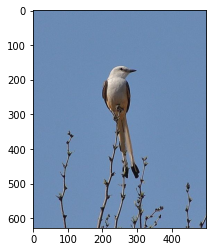

In [21]:
plt.imshow(Image.open(X_train[1]))

**Encode the Target Labels**

In [22]:
y_train

6158     353
39656    936
14580    372
13315    471
3264     769
        ... 
19183    539
4180     753
25773    366
3491     827
14100    359
Name: class_id, Length: 38849, dtype: object

In [23]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [24]:
lb.classes_

array(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007',
       '1008', '1009', '1010', '295', '296', '297', '298', '299', '313',
       '314', '315', '316', '317', '318', '319', '320', '321', '322',
       '323', '324', '325', '326', '327', '328', '329', '330', '331',
       '332', '333', '334', '335', '336', '337', '338', '339', '340',
       '341', '342', '343', '344', '345', '346', '347', '348', '349',
       '350', '351', '352', '353', '354', '355', '356', '357', '358',
       '359', '360', '361', '362', '363', '364', '365', '366', '367',
       '368', '369', '370', '371', '372', '373', '374', '375', '376',
       '377', '378', '379', '380', '381', '382', '392', '393', '394',
       '395', '396', '397', '398', '399', '400', '401', '402', '446',
       '447', '448', '449', '450', '451', '452', '453', '454', '455',
       '456', '457', '458', '459', '460', '461', '462', '463', '464',
       '465', '466', '467', '468', '469', '470', '471', '472', '473',
       '474', '4

In [25]:
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)

In [26]:
y_train_bin[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
N_CLASSES = len(lb.classes_)

In [28]:
def parse_img_label(filename, label):

    # Read an image from a file
    image_string = tf.io.read_file(filename)

    # Decode it into a  vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)

    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])

    # Normalize the image
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

In [29]:
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 32 # Shuffle the training data by a chunck of 1024 observations

In [32]:
def gen_dataset(filenames, labels, is_training=True):

 
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_img_label, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [33]:
batch_size = 32
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [34]:
train_ds = gen_dataset(X_train, y_train_bin)
val_ds = gen_dataset(X_val, y_val_bin)

In [35]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layer2'),
    layers.Dense(N_CLASSES, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               524800    
_________________________________________________________________
output (Dense)               (None, 555)               284715    
Total params: 4,379,243
Trainable params: 2,121,259
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics='accuracy')
    



In [ ]:
history = model.fit(train_ds,batch_size=32, epochs=3, validation_data=val_ds,validation_batch_size= 32)

Epoch 1/3


In [ ]:
def show_prediction(model, img_path, df_target):

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    print(prediction)
    prediction = pd.Series(prediction[0])
    prediction.index = lb.classes_
    prediction = prediction[prediction==1].index.values
    print(prediction)

    class_description ="Not Found"

    #Get the class description of the bird
    if prediction[0] != "" :
      class_description = df_target.loc[df_target['class_id']== prediction[0]]['class_description'].iloc[0]
    else:
      prediction = "Not Found"


    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\nPrediction\n{}\n'.format(list(prediction)), fontsize=9)
    plt.title('\nBird class\n{}\n'.format(class_description), fontsize=9)
    plt.show()

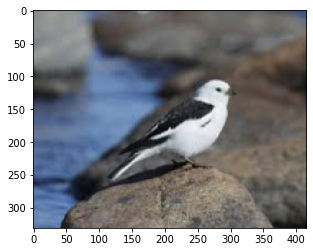

In [ ]:
img_path='/content/drive/MyDrive/Bird/bird_predict/009.jpg'
plt.imshow(Image.open(img_path))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
['856']


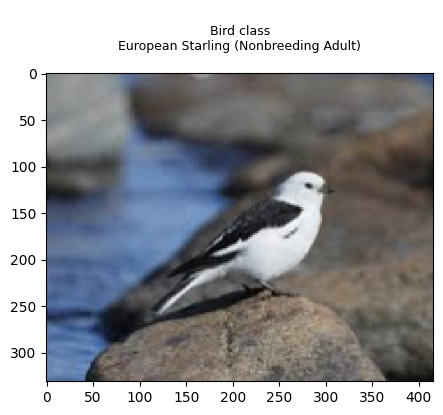

In [ ]:
show_prediction(model,img_path, df_target )

In [ ]:
cleaned_X = df_target.loc[:,'image_location']
cleaned_Y = df_target.loc[:,'class_id']

In [ ]:
def split_data(cleaned_X, cleaned_Y):
    # TODO: split the data
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    X_train, X_test, Y_train, Y_test = train_test_split(cleaned_X, cleaned_Y, train_size=0.5)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, train_size=0.4)
    
    return X_val, X_test, X_train, Y_val, Y_test, Y_train

X_val, X_test, X_train, Y_val, Y_test, Y_train = split_data(cleaned_X, cleaned_Y)

In [ ]:
X_train.shape,X_val.shape,X_test.shape

((1093,), (437,), (656,))

In [ ]:
# Train df
df_train = pd.DataFrame(columns=['image_location','category'])
df_train['image_location'] = X_train
df_train['category'] = Y_train

# Test df
df_val= pd.DataFrame(columns=['image_location','category'])
df_val['image_location'] = X_val
df_val['category'] = Y_val


# Test df
df_test= pd.DataFrame(columns=['image_location','category'])
df_test['image_location'] = X_test
df_test['category'] = Y_test

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
df_train.head(10)

,image_location,category
0,0856/29d9700972a74af183229cee3ca424d4.jpg,856
1,0900/7f8a09bebc3c42488f16af785a08609f.jpg,900
2,0400/ade28accf1ab4a35acc72f22f1154d28.jpg,400
3,0400/04d5e9dd87654420a03f64de14aecbd4.jpg,400
4,0988/80e354caf3cb4919b4b5b6a35360af39.jpg,988
5,0979/216d6a23a9054dea8a80e27daf93512b.jpg,979
6,0652/18cd148a26f340f7acea2a51d0422d13.jpg,652
7,0817/a6e7345b870c405b9b92cde6eb7db797.jpg,817
8,0947/cf1735c087f04eaa9c7cb9f7e9943f1f.jpg,947
9,0979/b5050cffc5bf4097b192317a45d97c80.jpg,979


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

dir_path = '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/'


datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=False, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

train_generator_df = datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=dir_path,
                                              x_col="image_location", 
                                              y_col="category", 
                                              class_mode="categorical", 
                                              target_size=(224, 224), 
                                              batch_size=1,
                                              rescale=1.0/255,
                                              seed=2020)

Found 1093 validated image filenames belonging to 22 classes.


In [ ]:
valid_generator_df = datagen.flow_from_dataframe(dataframe=df_val, 
                                              directory=dir_path,
                                              x_col="image_location", 
                                              y_col="category", 
                                              class_mode="categorical", 
                                              target_size=(224, 224), 
                                              batch_size=1,
                                              rescale=1.0/255,
                                              seed=2020)

Found 437 validated image filenames belonging to 22 classes.


In [ ]:
test_generator_df = datagen.flow_from_dataframe(dataframe=df_test, 
                                              directory=dir_path,
                                              x_col="image_location", 
                                              y_col="category", 
                                              class_mode="categorical", 
                                              target_size=(224, 224), 
                                              batch_size=1,
                                              rescale=1.0/255,
                                              seed=2020)

Found 656 validated image filenames belonging to 22 classes.


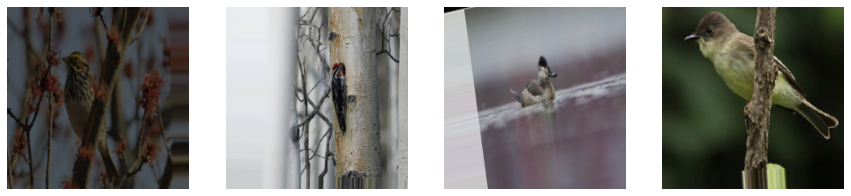

In [ ]:
# plotting images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator_df)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

In [ ]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
N_CLASSES = 22

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layer2'),
    layers.Dense(N_CLASSES, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               524800    
_________________________________________________________________
output (Dense)               (None, 22)                11286     
Total params: 4,105,814
Trainable params: 1,847,830
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics='accuracy')
    

In [ ]:
batch_size=32
model.fit_generator(train_generator_df, 
                    epochs=50,  # one forward/backward pass of training data
                    steps_per_epoch=df_train.shape[0]//batch_size,  # number of images comprising of one epoch
                    validation_data=valid_generator_df,
                    validation_steps=df_test.shape[0]//batch_size)

Epoch 1/50
34/34 [==============================] - 23s 504ms/step - loss: 0.3542 - accuracy: 0.0148 - val_loss: 0.2567 - val_accuracy: 0.1000
Epoch 2/50
34/34 [==============================] - 15s 452ms/step - loss: 0.2388 - accuracy: 0.0000e+00 - val_loss: 0.1910 - val_accuracy: 0.0500
Epoch 3/50
34/34 [==============================] - 14s 414ms/step - loss: 0.1962 - accuracy: 0.1209 - val_loss: 0.2039 - val_accuracy: 0.0500
Epoch 4/50
34/34 [==============================] - 12s 361ms/step - loss: 0.1960 - accuracy: 0.0322 - val_loss: 0.2075 - val_accuracy: 0.1500
Epoch 5/50
34/34 [==============================] - 13s 377ms/step - loss: 0.2070 - accuracy: 0.0174 - val_loss: 0.1892 - val_accuracy: 0.1500
Epoch 6/50
34/34 [==============================] - 11s 315ms/step - loss: 0.1876 - accuracy: 0.1036 - val_loss: 0.1965 - val_accuracy: 0.0000e+00
Epoch 7/50
34/34 [==============================] - 11s 309ms/step - loss: 0.1820 - accuracy: 0.1753 - val_loss: 0.1551 - val_accuracy

In [ ]:
def show_prediction(model, img_path, df_target):

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    print(prediction)
    prediction = pd.Series(prediction[0])
    prediction.index = lb.classes_
    prediction = prediction[prediction==1].index.values
    print(prediction)

    class_description ="Not Found"

    #Get the class description of the bird
    if prediction[0] != "" :
      class_description = df_target.loc[df_target['class_id']== prediction[0]]['class_description'].iloc[0]
    else:
      prediction = "Not Found"


    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\nPrediction\n{}\n'.format(list(prediction)), fontsize=9)
    plt.title('\nBird class\n{}\n'.format(class_description), fontsize=9)
    plt.show()